# Topic Modeling with Gensim

- Wie können wir rausfinden um welche Themen sich die Texte drehen?
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
- TODO https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

## Modelle runterladen

In [1]:
# Download stopwords nltk
import nltk; 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/plotti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Download spacy model
# !python2.7 -m spacy download en

## Pakete installieren

- ```pip3 install --user gensim```
- ```pip3 install --user pyLDAvis```

# Pakete importieren

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

#Data 
import requests
from bs4 import BeautifulSoup

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
spacy.load('en')

# LDA

- LDA (Latent Dirichlitet Allocation) sieht jedes Dokument als eine Sammlung von Themen
- Jedes Thema wiederrum ist eine sammlung von Wörtern
- Sobald man als Nutzer die Anzahl der Topics festgelegt hat versucht der Algorithmus die Topics so auf die Dokumente zu verteilen, dass es möglichst optimal ist. 
- Ein Thema ist also nur eine Sammlung von "dominanten" Wörtern für das Thema
- Als Mensch muss man dann dem Kind noch einen Namen geben

Das Endresultat hängt von folgenden Faktoren ab:
    - Die Qualität des Preprocessing 
    - Die Vielfalt der Themen die die Texte behandeln
    - Die Wahl des Topic modeling algorithmus
    - Die Anzahl der Topics die wir haben möchten
    - Den tuning Parametern

# Daten importieren
- Wir holen uns die Daten von der Frontpage von Swissinfo

In [44]:
url = "https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44571990"
tmp = requests.get(url)

In [61]:
soup = BeautifulSoup(tmp.json()["htmldetail"], "lxml")


u'The sprayer of Zurich  Harald Naegeli: a retrospective  After waiting more than a decade, controversial Swiss graffiti artist Harald Naegeli\xa0has been given the thumbs-up\xa0to spray the walls of Zurich\u2019s historic Grossm\xfcnster church.\xa0\xa0 The proposal by the 78-year-old artist to graffiti the inner walls of the Grossm\xfcnster towers has been accepted by both the church administration and the cantonal building authorities.\xa0 After illegally spraying numerous buildings,\xa0including churches,\xa0in the 1970s, Naegeli decided to apply for a permit to graffiti the\xa0Zurich landmark.\xa0 The towers of Grossm\xfcnster in the city of Zurich. (Z\xfcrich Tourism) Enfant terrible\xa0 In the 1980s he drew support and opposition\xa0from intellectuals and the general public alike for his illegal graffiti. After serving a prison sentence\xa0in 1984 for\xa0illegal defacement of property, he returned to Germany where he had been living before being incarcerated.\xa0 +\xa0The \u2018

In [62]:
import requests

items = []
raw_data = []
for i in range(1,10):
    start = (i-1)*100
    end =  i*100
    print("start %s end %s" %(start,end))
    url = "https://www.swissinfo.ch/eng/%s/%s?view=loadMore&end=%s&begin=%s" % (start,end,end,start)
    print(url)
    results = requests.get(url)
    page_content = BeautifulSoup(results.content, "html.parser")
    for link in page_content.select("h3 a"):
        id = link["href"].split("/")[-1]
        url = "https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=%s" % id
        print("--%s" % url)
        tmp = requests.get(url)
        detail_url = "https://www.swissinfo.ch%s" % tmp.json()["item"]["url"]
        print("--%s" % detail_url)
        r = requests.get(detail_url).json()
        try:
            tag = r["header"]["subjectTags"][0]["title"]
        except:
            tag = ""
        soup = BeautifulSoup(r["htmldetail"], "lxml")
        text = " ".join([text.get_text() for text in soup.find_all(['h1', 'h2', 'h3', 'h4', 'h5', "p"])])
        try:
            url = r["header"]["canonical"]
        except:
            url = ""
        raw_data.append(r)
        items.append({"id": id, "url": url, "tag": tag, "text": text})

start 0 end 100
https://www.swissinfo.ch/eng/0/100?view=loadMore&end=100&begin=0
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44574850
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44574850
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44609546
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44609546
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44609428
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44609428
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44593580
--https://www.swissinfo.ch/webservice/swi-eng-2.0/video/42579874/44593580
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44608456
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44608456
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44572400
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44572400
--

--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44572878
--https://www.swissinfo.ch/webservice/swi-eng-2.0/gallery/42579876/44572878
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44564548
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44564548
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44551128
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44551128
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=42219238
--https://www.swissinfo.ch/webservice/swi-eng-2.0/gallery/42579876/42219238
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44538252
--https://www.swissinfo.ch/webservice/swi-eng-2.0/gallery/42579876/44538252
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44565850
--https://www.swissinfo.ch/webservice/swi-eng-2.0/detail/42579872/44565850
--https://www.swissinfo.ch/webservice/swi-eng-2.0/deeplink?contentId=44566772
-

In [63]:
items[0]

{'id': u'44574850',
 'tag': u'Culture',
 'text': u'Yodellers hit the high notes as the tradition evolves.\xa0 Yodelling has come a long way since it was used by herdsmen\xa0to call their animals or communicate\xa0between Alpine villages. People are expected to have singing lessons before applying to join a yodelling club. Now a university in Lucerne has gone one step further, offering a bachelor course majoring in yodelling.\xa0 The multi-pitched "yelling"\xa0that has become part of Swiss traditional lore and musical expression can be learned\xa0and finessed in workshops\xa0across the north of the country, offered by the Swiss Yodelling Association.\xa0swissinfo.ch visited a beginner\u2019s class in Emmenbr\xfccke, canton Lucerne, to find out how people learn to do it. This group has been training for five evenings as part of the course\xa0under the tuition of Ursula Gernet, a solo yodeller and choir director. Most of the students had a good grasp of the singing form\xa0before starting

In [64]:
df = pd.DataFrame(items)
df.head()

,id,tag,text,url
0,44574850,Culture,Yodellers hit the high notes as the tradition ...,https://www.swissinfo.ch/eng/culture/something...
1,44609546,Politics,"In 2016, air traffic was responsible for about...",https://www.swissinfo.ch/eng/politics/environm...
2,44609428,Business,Ivan Glasenberg has been the CEO of Glencore s...,https://www.swissinfo.ch/eng/business/glencore...
3,44593580,Politics,Just when British Prime Minister Theresa May t...,
4,44608456,Politics,The smaller of the two chambers of the Swiss p...,https://www.swissinfo.ch/eng/2019-elections-an...


# Bereinigen

In [113]:
# Convert to list
data = df.text.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent).encode('utf-8') for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1][0].split(" ")[0:50])


['Yodellers', 'hit', 'the', 'high', 'notes', 'as', 'the', 'tradition', 'evolves.\xc2\xa0', 'Yodelling', 'has', 'come', 'a', 'long', 'way', 'since', 'it', 'was', 'used', 'by', 'herdsmen\xc2\xa0to', 'call', 'their', 'animals', 'or', 'communicate\xc2\xa0between', 'Alpine', 'villages.', 'People', 'are', 'expected', 'to', 'have', 'singing', 'lessons', 'before', 'applying', 'to', 'join', 'a', 'yodelling', 'club.', 'Now', 'a', 'university', 'in', 'Lucerne', 'has', 'gone', 'one']


## Tokenization und weiteres pre-processing

In [66]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])[0][0:20]

[u'yodellers', u'hit', u'the', u'high', u'notes', u'as', u'the', u'tradition', u'evolves', u'yodelling', u'has', u'come', u'long', u'way', u'since', u'it', u'was', u'used', u'by', u'herdsmen']


# Bigrams  und Trigrams erstellen

In [73]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

[u'yodellers', u'hit', u'the', u'high', u'notes', u'as', u'the', u'tradition', u'evolves', u'yodelling', u'has', u'come', u'long', u'way', u'since', u'it_was', u'used', u'by', u'herdsmen', u'to', u'call', u'their', u'animals', u'or', u'communicate', u'between', u'alpine', u'villages', u'people', u'are_expected', u'to', u'have', u'singing', u'lessons', u'before', u'applying', u'to', u'join', u'yodelling', u'club', u'now', u'university', u'in', u'lucerne', u'has', u'gone', u'one', u'step', u'further', u'offering', u'bachelor', u'course', u'majoring', u'in', u'yodelling', u'the', u'multi', u'pitched', u'yelling', u'that', u'has_become', u'part_of', u'swiss', u'traditional', u'lore', u'and', u'musical', u'expression', u'can_be', u'learned', u'and', u'finessed', u'in', u'workshops', u'across', u'the', u'north', u'of', u'the', u'country', u'offered', u'by', u'the', u'swiss', u'yodelling_association', u'swissinfo_ch', u'visited', u'beginner', u'class', u'in', u'emmenbrucke', u'canton', u'luce

## Stopwörter entfernen, POS Filtering und Lemmatization

In [91]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# Custom Stopwords
stop_words.extend(['swiss', "switzerland", "swi", 'fintech', 'array', 'click', 'head', 'html', 'email', 'css', 'society', 'array', 'jquery', 'keystone', 'mailchimp'])

In [92]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [93]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


[[u'yodeller', u'hit', u'high', u'note', u'tradition', u'evolf', u'yodel', u'come', u'long', u'way', u'use', u'herdsman', u'call', u'animal', u'communicate', u'alpine', u'village', u'people', u'expect', u'singing', u'lesson', u'apply', u'join', u'yodel', u'club', u'university', u'lucerne', u'go', u'step', u'offer', u'bachelor', u'course', u'major', u'yodel', u'multi', u'pitch', u'yelling', u'become', u'part', u'traditional', u'lore', u'musical', u'expression', u'learn', u'finessed', u'workshop', u'north', u'country', u'offer', u'yodelling_association', u'swissinfo_ch', u'visit', u'beginner', u'class', u'emmenbrucke', u'canton', u'lucerne', u'find', u'people', u'learn', u'group', u'train', u'evening', u'part', u'course', u'tuition', u'ursula', u'gernet', u'solo', u'yodeller', u'choir', u'director', u'student', u'good', u'grasp', u'singing', u'form', u'start', u'course', u'learn', u'parent', u'sing', u'course', u'yodelling', u'beginner', u'yodel', u'also', u'take', u'centre', u'stage', u

# Create Dictionairy for LDA
- Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

- For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

- This is used as the input by the LDA model.

In [94]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 3), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 5), (10, 4), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 3), (22, 2), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 3), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 7), (52, 1), (53, 1), (54, 3), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 3), (87, 2), (88, 1), (89, 1), (90, 1), (91, 2), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 2), (107, 1), (108, 2), (109, 1), (110, 1)

- Inverse lookup:

In [95]:
id2word[0]

u'academi'

In [96]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(u'academi', 1),
  (u'academic', 3),
  (u'academy', 1),
  (u'accordion', 1),
  (u'active', 1),
  (u'add', 2),
  (u'advance', 1),
  (u'aesthetic', 1),
  (u'alpine', 1),
  (u'also', 5),
  (u'amateur', 4),
  (u'ancient', 1),
  (u'animal', 1),
  (u'anthropologist', 1),
  (u'apply', 2),
  (u'approach', 1),
  (u'art', 1),
  (u'attract', 1),
  (u'audience', 1),
  (u'authentic', 2),
  (u'autumn', 1),
  (u'bachelor', 3),
  (u'become', 2),
  (u'beginner', 2),
  (u'believe', 1),
  (u'benefit', 1),
  (u'bern', 1),
  (u'blow', 1),
  (u'boom', 1),
  (u'branch', 1),
  (u'brig', 1),
  (u'brilliant', 1),
  (u'britain', 1),
  (u'britta', 1),
  (u'call', 1),
  (u'canton', 1),
  (u'canton_valai', 1),
  (u'carefully', 1),
  (u'centre', 1),
  (u'change', 1),
  (u'choir', 2),
  (u'class', 1),
  (u'club', 1),
  (u'come', 3),
  (u'communicate', 1),
  (u'competition', 1),
  (u'context', 1),
  (u'continued', 1),
  (u'convinced', 1),
  (u'could', 1),
  (u'country', 1),
  (u'course', 7),
  (u'dayana', 1),
  (u'd

# Build LDA Model

In [97]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View LDA Model

In [98]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  u'0.009*"say" + 0.006*"woman" + 0.005*"country" + 0.005*"get" + 0.005*"migration" + 0.005*"see" + 0.004*"people" + 0.004*"sign" + 0.003*"josephine" + 0.003*"government"'),
 (1,
  u'0.011*"say" + 0.006*"also" + 0.006*"city" + 0.005*"work" + 0.004*"research" + 0.004*"make" + 0.004*"see" + 0.004*"swissinfo_ch" + 0.004*"project" + 0.003*"report"'),
 (2,
  u'0.009*"say" + 0.006*"human_right" + 0.005*"see" + 0.005*"also" + 0.005*"country" + 0.004*"people" + 0.004*"swissinfo_ch" + 0.004*"get" + 0.004*"take" + 0.004*"glencore"'),
 (3,
  u'0.006*"tax" + 0.006*"say" + 0.004*"co" + 0.004*"emission" + 0.004*"woman" + 0.004*"canton" + 0.004*"senate" + 0.004*"country" + 0.004*"see" + 0.004*"party"'),
 (4,
  u'0.010*"say" + 0.008*"initiative" + 0.007*"vote" + 0.006*"voter" + 0.005*"would" + 0.005*"also" + 0.004*"see" + 0.004*"horn" + 0.004*"could" + 0.004*"get"'),
 (5,
  u'0.009*"say" + 0.005*"company" + 0.005*"use" + 0.004*"government" + 0.004*"country" + 0.004*"include" + 0.004*"technology" 

# How good is the model?

In [99]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

('\nPerplexity: ', -8.161378733581577)
('\nCoherence Score: ', 0.2810859129638888)


- Everything below a coherence score of 0.5 is quite bad

# Visualize topic keywords
- Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.
- A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.
- A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.
- If you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

In [100]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      23.889647        1       1 -0.013609  0.004777
4      19.013580        1       2  0.023006 -0.081355
1      16.721378        1       3  0.027126  0.120781
0      14.329741        1       4 -0.106042  0.005799
5      13.915154        1       5  0.103587 -0.017640
3      12.130504        1       6 -0.034068 -0.032362, topic_info=     Category       Freq              Term       Total  loglift  logprob
term                                                                    
6243  Default  34.000000               tax   34.000000  30.0000  30.0000
1619  Default  46.000000             voter   46.000000  29.0000  29.0000
1630  Default  28.000000              horn   28.000000  28.0000  28.0000
1042  Default  26.000000         migration   26.000000  27.0000  27.0000
3486  Default  85.000000        initiative   85.000000  26.0000  26.0000
1142  Default  18.000000            senate   18.000000  25.0000  25.0000
1463  Default  26.000000                co   26.000000  24.0000  24.0000
580   Default  68.000000              vote   68.000000  23.0000  23.0000
881   Default  21.000000          emission   21.000000  22.0000  22.0000
6345  Default  19.000000             yodel   19.000000  21.0000  21.0000
3776  Default  17.000000         josephine   17.000000  20.0000  20.0000
2038  Default  22.000000           teacher   22.000000  19.0000  19.0000
2879  Default  16.000000      swisscontact   16.000000  18.0000  18.0000
3183  Default  22.000000         education   22.000000  17.0000  17.0000
2629  Default  64.000000       human_right   64.000000  16.0000  16.0000
5771  Default  85.000000             woman   85.000000  15.0000  15.0000
3562  Default  38.000000          glencore   38.000000  14.0000  14.0000
1828  Default  19.000000               cow   19.000000  13.0000  13.0000
699   Default  36.000000        technology   36.000000  12.0000  12.0000
3574  Default  21.000000           dignita   21.000000  11.0000  11.0000
3914  Default  14.000000              seat   14.000000  10.0000  10.0000
944   Default  34.000000          research   34.000000   9.0000   9.0000
582   Default  68.000000              city   68.000000   8.0000   8.0000
1455  Default  15.000000             darpa   15.000000   7.0000   7.0000
2657  Default  14.000000              pact   14.000000   6.0000   6.0000
5006  Default  19.000000  assisted_suicide   19.000000   5.0000   5.0000
3870  Default  38.000000            canton   38.000000   4.0000   4.0000
5315  Default  15.000000           implant   15.000000   3.0000   3.0000
3620  Default  46.000000              bern   46.000000   2.0000   2.0000
5998  Default  29.000000               art   29.000000   1.0000   1.0000
...       ...        ...               ...         ...      ...      ...
856    Topic6   4.114460            legend    5.646426   1.7929  -6.9087
5837   Topic6  13.238317   federal_council   38.071098   1.0531  -5.7401
1827   Topic6   9.667957           climate   22.846750   1.2495  -6.0544
3620   Topic6  14.479243              bern   46.368858   0.9455  -5.6505
1851   Topic6   6.495262               air   12.285797   1.4721  -6.4521
6225   Topic6  14.236117        parliament   53.359127   0.7882  -5.6674
5771   Topic6  16.731915             woman   85.235733   0.4813  -5.5059
1079   Topic6   7.269294    representative   16.424782   1.2943  -6.3395
4221   Topic6   8.875490             house   25.379562   1.0588  -6.1399
4989   Topic6   9.893148               end   32.322754   0.9255  -6.0314
2450   Topic6   6.687507            amount   13.945659   1.3745  -6.4230
602    Topic6  26.206469               say  305.468872  -0.3464  -5.0572
960    Topic6   9.261760            number   28.929085   0.9705  -6.0973
208    Topic6  14.492488   free_newsletter   83.666359   0.3562  -5.6496
5731   Topic6  14.488978        top_storie   83.666000   0.3560  -5.6498
6108   Topic6  14.472

# LDA Mallet model

In [141]:
mallet_path = '/Users/plotti/code/text/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMalblet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)


In [142]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(9,
  [(u'research', 0.025691699604743084),
   (u'project', 0.025032938076416336),
   (u'university', 0.0230566534914361),
   (u'technology', 0.021739130434782608),
   (u'teacher', 0.017786561264822136),
   (u'work', 0.017127799736495388),
   (u'good', 0.017127799736495388),
   (u'education', 0.017127799736495388),
   (u'learn', 0.015810276679841896),
   (u'level', 0.014492753623188406)]),
 (6,
  [(u'party', 0.029510395707578806),
   (u'parliament', 0.02414486921529175),
   (u'government', 0.02079141515761234),
   (u'politician', 0.018108651911468814),
   (u'federal_council', 0.017437961099932932),
   (u'political', 0.01676727028839705),
   (u'call', 0.01609657947686117),
   (u'senate', 0.014755197853789403),
   (u'minister', 0.012743125419181758),
   (u'representative', 0.011401743796109993)]),
 (7,
  [(u'initiative', 0.041254125412541254),
   (u'voter', 0.029152915291529153),
   (u'vote', 0.024752475247524754),
   (u'campaign', 0.019801980198019802),
   (u'people_party', 0.018701870

In [231]:
pyLDAvis.enable_notebook()
lda_model_2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim.prepare(lda_model_2, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      24.486205        1       1  0.001101  0.000220
1      19.713692        1       2 -0.000328 -0.000485
3      19.400036        1       3 -0.000006 -0.000793
4      19.178673        1       4 -0.000359  0.000519
2      17.221393        1       5 -0.000408  0.000539, topic_info=     Category      Freq              Term     Total  loglift  logprob
term                                                                 
4631  Default  5.000000          postpone  5.000000  30.0000  30.0000
3438  Default  5.000000           explain  5.000000  29.0000  29.0000
3040  Default  4.000000             thank  4.000000  28.0000  28.0000
964   Default  4.000000           probity  4.000000  27.0000  27.0000
6079  Default  5.000000   social_detectif  5.000000  26.0000  26.0000
6055  Default  5.000000          obstacle  5.000000  25.0000  25.0000
5521  Default  5.000000           outcome  5.000000  24.0000  24.0000
89    Default  5.000000           machine  5.000000  23.0000  23.0000
3376  Default  5.000000         signature  5.000000  22.0000  22.0000
149   Default  5.000000              wash  5.000000  21.0000  21.0000
3266  Default  5.000000               dry  5.000000  20.0000  20.0000
93    Default  5.000000       make_friend  5.000000  19.0000  19.0000
6405  Default  5.000000         longchamp  5.000000  18.0000  18.0000
1321  Default  5.000000       educational  5.000000  17.0000  17.0000
2691  Default  5.000000        ambassador  5.000000  16.0000  16.0000
2623  Default  5.000000         days_sign  5.000000  15.0000  15.0000
2000  Default  5.000000        superpower  5.000000  14.0000  14.0000
1483  Default  5.000000          freeport  5.000000  13.0000  13.0000
1503  Default  4.000000              balz  4.000000  12.0000  12.0000
475   Default  5.000000             scope  5.000000  11.0000  11.0000
2664  Default  4.000000             fleet  4.000000  10.0000  10.0000
584   Default  5.000000               uks  5.000000   9.0000   9.0000
3154  Default  5.000000            museum  5.000000   8.0000   8.0000
4504  Default  5.000000           compose  5.000000   7.0000   7.0000
2051  Default  5.000000            rarely  5.000000   6.0000   6.0000
5151  Default  5.000000              efta  5.000000   5.0000   5.0000
4021  Default  5.000000         pronounce  5.000000   4.0000   4.0000
4817  Default  5.000000             dryer  5.000000   3.0000   3.0000
6191  Default  4.000000         wrestling  4.000000   2.0000   2.0000
1335  Default  5.000000        vaccinated  5.000000   1.0000   1.0000
...       ...       ...               ...       ...      ...      ...
1824   Topic5  1.064452        rapporteur  5.023581   0.2073  -8.6112
4801   Topic5  1.119280           interim  5.283007   0.2072  -8.5609
4255   Topic5  1.098719           travail  5.189953   0.2064  -8.5795
2664   Topic5  1.056561             fleet  4.994432   0.2057  -8.6186
4545   Topic5  1.081545   economic_affair  5.126441   0.2030  -8.5952
1546   Topic5  1.049598        public_eye  4.979282   0.2021  -8.6252
4122   Topic5  1.092609           hitachi  5.186652   0.2015  -8.5851
2740   Topic5  1.039171       taking_part  4.947205   0.1986  -8.6352
2106   Topic5  1.152022               non  5.485479   0.1984  -8.5321
1225   Topic5  1.092394             essay  5.209356   0.1969  -8.5853
1579   Topic5  1.042684      construction  4.974858   0.1964  -8.6318
3686   Topic5  1.058909            favour  5.063351   0.1942  -8.6164
4641   Topic5  1.101484            lavrov  5.277302   0.1923  -8.5770
5315   Topic5  1.112934           implant  5.384320   0.1825  -8.5666
6464   Topic5  1.103246           firstly  5.327894   0.1843  -8.5754
3954   Topic5  1.120859              mary  5.435254   0.1802  -8.5595
2654   Topic5  1.145836     determination  5.636991   0.1658  -8.5375
757    Topic5  1.105817          shechita  5.370092   0.1788  -8.5730
1932   To

# Compute the optimal number of topics

In [143]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print("Working on %s" % (num_topics))
        #model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=num_topics, random_state=100,update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [144]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=3)

Working on 2
Working on 5
Working on 8
Working on 11
Working on 14
Working on 17
Working on 20
Working on 23
Working on 26
Working on 29
Working on 32
Working on 35
Working on 38


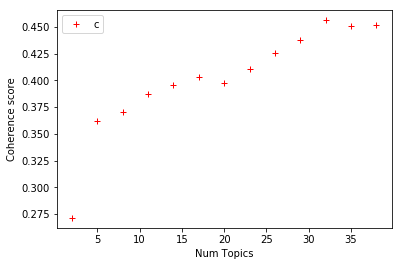

In [154]:
# Show graph
limit=40; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values,'r+')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [146]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

('Num Topics =', 2, ' has Coherence Value of', 0.2713)
('Num Topics =', 5, ' has Coherence Value of', 0.3616)
('Num Topics =', 8, ' has Coherence Value of', 0.3702)
('Num Topics =', 11, ' has Coherence Value of', 0.3867)
('Num Topics =', 14, ' has Coherence Value of', 0.3959)
('Num Topics =', 17, ' has Coherence Value of', 0.4029)
('Num Topics =', 20, ' has Coherence Value of', 0.3974)
('Num Topics =', 23, ' has Coherence Value of', 0.4104)
('Num Topics =', 26, ' has Coherence Value of', 0.4255)
('Num Topics =', 29, ' has Coherence Value of', 0.4381)
('Num Topics =', 32, ' has Coherence Value of', 0.4561)
('Num Topics =', 35, ' has Coherence Value of', 0.4509)
('Num Topics =', 38, ' has Coherence Value of', 0.4518)


- Lets pick model 17. It has a high value before it starts flattening out. 

In [155]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=5))

[(0,
  u'0.014*"initiative" + 0.011*"country" + 0.011*"vote" + 0.010*"human_right" + 0.010*"law"'),
 (1,
  u'0.013*"country" + 0.012*"company" + 0.011*"report" + 0.011*"business" + 0.009*"include"'),
 (2,
  u'0.019*"woman" + 0.012*"people" + 0.012*"top_storie" + 0.012*"time" + 0.011*"sign"'),
 (3,
  u'0.015*"make" + 0.008*"good" + 0.007*"world" + 0.007*"year" + 0.007*"future"'),
 (4,
  u'0.014*"city" + 0.014*"zurich" + 0.013*"work" + 0.010*"geneva" + 0.009*"bern"')]


# Getting the most dominant topic for each Text

In [159]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.4268,"country, company, report, business, include, g...",Yodellers hit the high notes as the tradition ...
1,1,0.0,0.4135,"initiative, country, vote, human_right, law, g...","In 2016, air traffic was responsible for about..."
2,2,1.0,0.6025,"country, company, report, business, include, g...",Ivan Glasenberg has been the CEO of Glencore s...
3,3,0.0,0.3185,"initiative, country, vote, human_right, law, g...",Just when British Prime Minister Theresa May t...
4,4,0.0,0.6017,"initiative, country, vote, human_right, law, g...",The smaller of the two chambers of the Swiss p...
5,5,2.0,0.4069,"woman, people, top_storie, time, sign, free_ne...",A Honduran child cries while her mother is sea...
6,6,2.0,0.4358,"woman, people, top_storie, time, sign, free_ne...",The photographer Alberto Campi roamed the migr...
7,7,3.0,0.3918,"make, good, world, year, future, big, accord, ...","Index providers, including S&P Global, MSCI an..."
8,8,4.0,0.3679,"city, zurich, work, geneva, bern, life, year, ...","For some Catholics in Switzerland, theres disa..."
9,9,3.0,0.5962,"make, good, world, year, future, big, accord, ...","Due to global warming, natural disasters like ..."


# Find the most relevant document per topic

In [175]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7542,"initiative, country, vote, human_right, law, g...",Andrea Huber (left) and Hans-Ueli Vogt discuss...
1,1.0,0.7505,"country, company, report, business, include, g...",Petrobras Campos Basin offshore platform in Br...
2,2.0,0.6401,"woman, people, top_storie, time, sign, free_ne...",A worker cleans out a fire-damaged apartment w...
3,3.0,0.7270,"make, good, world, year, future, big, accord, ...",This past summer’s drought was hard on Swiss t...
4,4.0,0.6729,"city, zurich, work, geneva, bern, life, year, ...",The top lot - the pearl and diamond pendant - ...


# How are the topics distributed across all of our documents

In [177]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = topic_counts/topic_counts.sum()

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"initiative, country, vote, human_right, law, g...",26,0.262626
1,1.0,"country, company, report, business, include, g...",15,0.151515
2,2.0,"woman, people, top_storie, time, sign, free_ne...",21,0.212121
3,3.0,"make, good, world, year, future, big, accord, ...",15,0.151515
4,4.0,"city, zurich, work, geneva, bern, life, year, ...",22,0.222222


# Words per Document

In [192]:
doc_lenghts = [len(list(sent_to_words(d))) for d in df_dominant_topic.Text]
len(doc_lenghts)

99

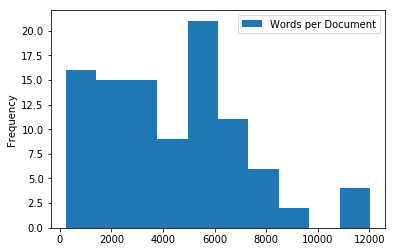

In [193]:
pd.DataFrame(doc_lenghts,columns=["Words per Document"]).plot(kind="hist")

# Distribution by Topic

In [198]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.4268,"country, company, report, business, include, g...",Yodellers hit the high notes as the tradition ...
1,1,0.0,0.4135,"initiative, country, vote, human_right, law, g...","In 2016, air traffic was responsible for about..."
2,2,1.0,0.6025,"country, company, report, business, include, g...",Ivan Glasenberg has been the CEO of Glencore s...
3,3,0.0,0.3185,"initiative, country, vote, human_right, law, g...",Just when British Prime Minister Theresa May t...
4,4,0.0,0.6017,"initiative, country, vote, human_right, law, g...",The smaller of the two chambers of the Swiss p...


In [212]:
df_dominant_topic["Text_Length"] = df_dominant_topic["Text"].str.len()
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Text_Length
0,0,1.0,0.4268,"country, company, report, business, include, g...",Yodellers hit the high notes as the tradition ...,4404
1,1,0.0,0.4135,"initiative, country, vote, human_right, law, g...","In 2016, air traffic was responsible for about...",3429
2,2,1.0,0.6025,"country, company, report, business, include, g...",Ivan Glasenberg has been the CEO of Glencore s...,11694
3,3,0.0,0.3185,"initiative, country, vote, human_right, law, g...",Just when British Prime Minister Theresa May t...,1670
4,4,0.0,0.6017,"initiative, country, vote, human_right, law, g...",The smaller of the two chambers of the Swiss p...,5762


In [220]:
tmp = df_dominant_topic.groupby(by="Dominant_Topic").agg({'Document_No':['count'], "Text_Length": "mean"}) 
tmp.columns = ["Documents","Average_Length"]
tmp = tmp.reset_index()

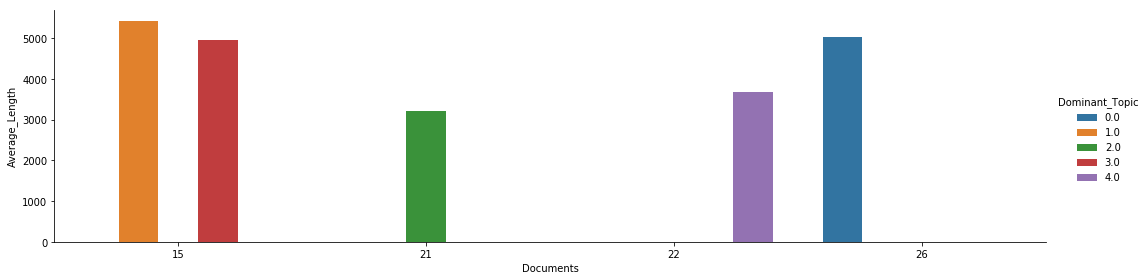

In [224]:
import seaborn as sns
g = sns.catplot(x="Documents", y="Average_Length", hue="Dominant_Topic",data=tmp, kind="bar",height=4, aspect=3.7)